# GoodReads NLP Analysis and WordCloud Generation

By: **Kyle Perez** 

This is an Analysis of the GoodReads "Books That Everyone Should Read At Least Once" list found on [Kaggle](https://www.kaggle.com/datasets/ishikajohari/best-books-10k-multi-genre-data). One of the main focuses of this project is Natural Language Processing (NLP). NLP enables computers to understand, interpret, and generate human language in a way that is both meaningful and contextually relevant.<br> 
The structure of the project is as follows:<br>
<a id="0"></a> 
### Table of Contents

1. [Dataframe Exploration & Cleaning](#1)
2. [Analysis](#2)
3. [Natural Language Processing](#3)
4. [Data Modeling](#4)

## Preparing the Environment

We will import the required libraries and read in the data set. 

In [54]:
# Standard Libraries 
import pandas as pd
import numpy as np 
import string
import re

# Data Visualization 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from  PIL import Image

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

# Collections
import collections
from collections import OrderedDict, Counter
import operator

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Ignore Warnings  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Read in data in CSV format
df = pd.read_csv('goodreads_data.csv')

---

<a id="1"></a>
## Dataframe Exploration

In [3]:
# Preveiw first 5 rows of data set
df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [4]:
# Preveiw last 5 rows of data set
df.tail()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
9995,9995,"Breeders (Breeders Trilogy, #1)",Ashley Quigley,How far would you go? If human society was gen...,"['Dystopia', 'Science Fiction', 'Post Apocalyp...",3.44,276,https://www.goodreads.com/book/show/22085400-b...
9996,9996,Dynamo,Eleanor Gustafson,Jeth Cavanaugh is searching for a new life alo...,[],4.23,60,https://www.goodreads.com/book/show/20862902-d...
9997,9997,The Republic of Trees,Sam Taylor,This dark fable tells the story of four Englis...,"['Fiction', 'Horror', 'Dystopia', 'Coming Of A...",3.29,383,https://www.goodreads.com/book/show/891262.The...
9998,9998,"Waking Up (Healing Hearts, #1)",Renee Dyer,For Adriana Monroe life couldn’t get any bette...,"['New Adult', 'Romance', 'Contemporary Romance...",4.13,263,https://www.goodreads.com/book/show/19347252-w...
9999,9999,Bits and Pieces: Tales and Sonnets,Jas T. Ward,After demands of thousands of fans in various ...,[],5.00,36,https://www.goodreads.com/book/show/21302552-b...


We notice there is a redundant index column in this data set. There are lists in the 'Genres' column with multiple genre types.  

Next, we will use the df.shape() and df.info() to get more information.

In [5]:
df.shape

(10000, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   10000 non-null  int64  
 1   Book         10000 non-null  object 
 2   Author       10000 non-null  object 
 3   Description  9923 non-null   object 
 4   Genres       10000 non-null  object 
 5   Avg_Rating   10000 non-null  float64
 6   Num_Ratings  10000 non-null  object 
 7   URL          10000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


There are 10,000 rows including the header and 8 columns with some missing descriptions. The only data type requiring manipulation is Num_Ratings. 

---

## Data Cleaning

Before we start the analysis we must first clean the data. 

For this NLP-focused analysis, we will look for missing descriptions and/or duplicate data.

**Handling Missing Values**

We will find where there are null values and drop them. 

In [7]:
df.isnull().sum()

Unnamed: 0      0
Book            0
Author          0
Description    77
Genres          0
Avg_Rating      0
Num_Ratings     0
URL             0
dtype: int64

So, there are 77 missing descriptions in this data set. We will drop these rows since we are text-mining descriptions. 

In [8]:
df.dropna(inplace=True)

**Duplicate Data**

Then, we will find out whether there is duplicate data. 

In [9]:
df.duplicated().sum()

0

There is no duplicate data. 

In [10]:
df.shape

(9923, 8)

At last! We can confirm that the rows with missing values have been dropped as the rows were 10,000 and now it's reduced to 9,923. 

**Data Type Manipulation**

Now, we will change the Num_Ratings into the correct data type, float. 

In [11]:
df['Num_Ratings'] = df['Num_Ratings'].str.replace(',', '', regex=True).astype(float)

**Feature Engineering**

Next, we will create a column for our prediction model. We will create a column that distinguishes if a book is fiction or non-fiction from the lists in 'Genres'.

- Fiction = 1 
- Non-Fiction = 0

To do this we will create a function and apply it to a new column.

In [12]:
def is_fiction(genres):
    return 1 if 'Fiction' in genres else 0

df['Fiction'] = df['Genres'].apply(is_fiction)

In [13]:
df.columns

Index(['Unnamed: 0', 'Book', 'Author', 'Description', 'Genres', 'Avg_Rating',
       'Num_Ratings', 'URL', 'Fiction'],
      dtype='object')

**Dropping Irrelevant Data**

We do not need the 'Unnamed: 0' or 'URL' columns. 

In [14]:
df = df.drop(['Unnamed: 0', 'URL'], axis=1)

df.head()

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,Fiction
0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,5691311.0,1
1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,9278135.0,1
2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,3944155.0,1
3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,3488438.0,0
4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,3575172.0,1


At last! The data is cleaned and ready for analysis. 

## Descriptive Statistics 

Here, we will do a descriptive statistical analysis. We use df.describe() and assign 'include = 'all' to ensure that categorical features are also included in the output.

In [15]:
df.describe(include='all')

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,Fiction
count,9923,9923,9923,9923,9923.000000,9.923000e+03,9923.000000
unique,9795,6009,9888,8022,NaN,NaN,NaN
top,"The Hunger Games (The Hunger Games, #1)",Stephen King,This is a reproduction of the original artefac...,[],NaN,NaN,NaN
freq,4,57,4,923,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,4.067502,9.377206e+04,0.592966
std,NaN,NaN,NaN,NaN,0.331937,3.433766e+05,0.491306
min,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000
25%,NaN,NaN,NaN,NaN,3.880000,5.615000e+02,0.000000
50%,NaN,NaN,NaN,NaN,4.070000,1.617000e+04,1.000000
75%,NaN,NaN,NaN,NaN,4.260000,6.522650e+04,1.000000


You will see 'NaN' in some of the categorical columns and that's perfectly fine. Categorical values are not meant to have calculations performed on them so, we can ignore those.

<a id="2"></a>
# Exploration of Ratings 

### Distribution of Average Rating

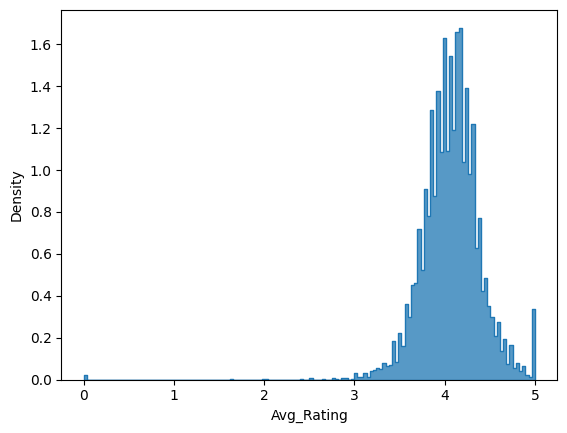

In [16]:
hist = sns.histplot(data=df, x='Avg_Rating', element='step', stat='density', common_norm=False)

plt.show()

Avg_Rating has a somewhat normal distribution but looks to be positively skewed with a high amount of 5-star ratings. 

### What books have the highest number of ratings and highest rating? 

In [17]:
# Sort DataFrame by Avg_Rating and Num_Ratings
top_rating = df.sort_values(by=['Avg_Rating', 'Num_Ratings'], ascending=False)

# Get the top 10 entries
top_10 = top_rating.head(10)

top_10

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,Fiction
6109,Nuestra Historia de Amor de Fracaso Hasta San ...,Athira Bhargavan,Este libro esta basado en el romance historia ...,[],5.0,92.0,0
9999,Bits and Pieces: Tales and Sonnets,Jas T. Ward,After demands of thousands of fans in various ...,[],5.0,36.0,0
5809,The Secrets of Albion Falls (The Secrets Serie...,Sass Cadeaux,Living a sequestered life in magical village n...,[],5.0,23.0,0
7920,Liam: Midsummer's Magic Bonus Book,Emmie Lou Kates,"""I can’t promise that I won’t screw things up ...",[],5.0,19.0,0
4603,"This Land of Streams: Spiritual, Friendship, R...",Maria Johnsen,You will find within this book Maria Johnsen's...,[],5.0,11.0,0
6151,Mavericks,Strider Marcus Jones,Read 10/52 poems and reviews from MAVERICKS fr...,[],5.0,11.0,0
6551,Quail Farming: Markets and Marketing Strategies,Francis Otieno,"Every few decades, a book is published that ch...",[],5.0,11.0,0
6281,The Illusion of Murder (Illusions and Shadows #1),Diane Henson,"Accused of murder, Rena is forced to flee the ...",[],5.0,10.0,0
6526,No Longer Shy: Conquering Shyness and Social A...,Reniel Anca,Build Confidence and Hack Your Way to a Fulfil...,[],5.0,10.0,0
6195,"Selfish: Permission to Pause, Live, Love and L...",Naketa Ren Thigpen,It’s time to redefine… Selfish women get the l...,[],5.0,9.0,0


The book with the highest number of ratings and a perfect five rating is the Spanish version of [Our Flop Love Story Till Valentine](https://www.goodreads.com/book/show/30512771-our-flop-love-story-till-valentine) by Athira Bhargavan. 

### How many books have a perfect rating of 5? 

In [18]:
count_5_rating = (df['Avg_Rating'] == 5.0).sum()

print(f'The number of books with a rating of 5 is: {count_5_rating}')

The number of books with a rating of 5 is: 115


### What ratings show up most frequently?

In [19]:
rating_counts = df['Avg_Rating'].value_counts().head()

print(rating_counts)

Avg_Rating
4.00    197
4.12    157
4.18    154
4.09    153
4.14    151
Name: count, dtype: int64


# Exploration of Genres 

In [20]:
# Access the 'Genre' column for the first row
genre_first_row = df['Genres'].iloc[0]

print(f'The Genres for the first row is: {genre_first_row}')

The Genres for the first row is: ['Classics', 'Fiction', 'Historical Fiction', 'School', 'Literature', 'Young Adult', 'Historical']


Each book has a list of multiple genres. We will create a dictionary to see the frequency of each genre in this data set. 

### What are the top 10 genres? 

In [21]:
# Split the genres string and create a list of all genres
genres_list = [genre.strip("[]").replace("'", "").split(", ") for genre in df['Genres']]
all_genres = [genre for sublist in genres_list for genre in sublist]

# Count the frequency of each genre
genre_counts = Counter(all_genres)

genre_counts.most_common(10)

[('Fiction', 5686),
 ('Nonfiction', 2323),
 ('Fantasy', 2192),
 ('Classics', 2123),
 ('Romance', 1552),
 ('Young Adult', 1520),
 ('Historical Fiction', 1481),
 ('Mystery', 1357),
 ('Contemporary', 1290),
 ('Audiobook', 1242)]

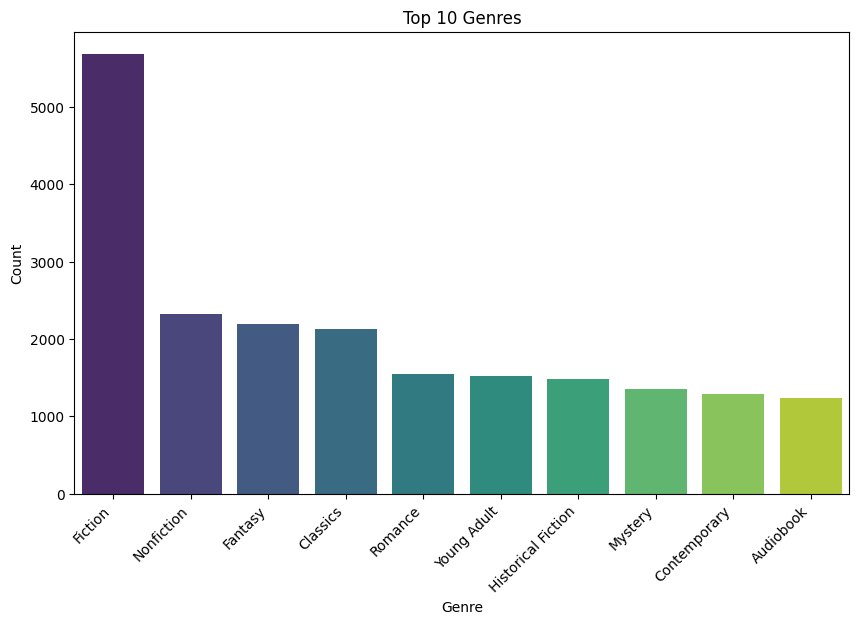

In [22]:
# Convert the dictionary to a DataFrame
df_genres = pd.DataFrame(list(genre_counts.items()), columns=['Genre', 'Count'])

# Sort the DataFrame by Count
df_genres = df_genres.sort_values(by='Count', ascending=False).head(10)

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Genre', y='Count', data=df_genres, palette='viridis')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Top 10 Genres')

plt.show()

Non-Fiction books are the top genre on this list by a significant margin.

In [23]:
# Convert the list to a pandas Series
genres_series = pd.Series(all_genres)

# Count the number of unique genres
unique_genres_count = genres_series.nunique()

print(f'The number of unique genres is: {unique_genres_count}')

The number of unique genres is: 618


### Who are the most frequent authors on this list? 

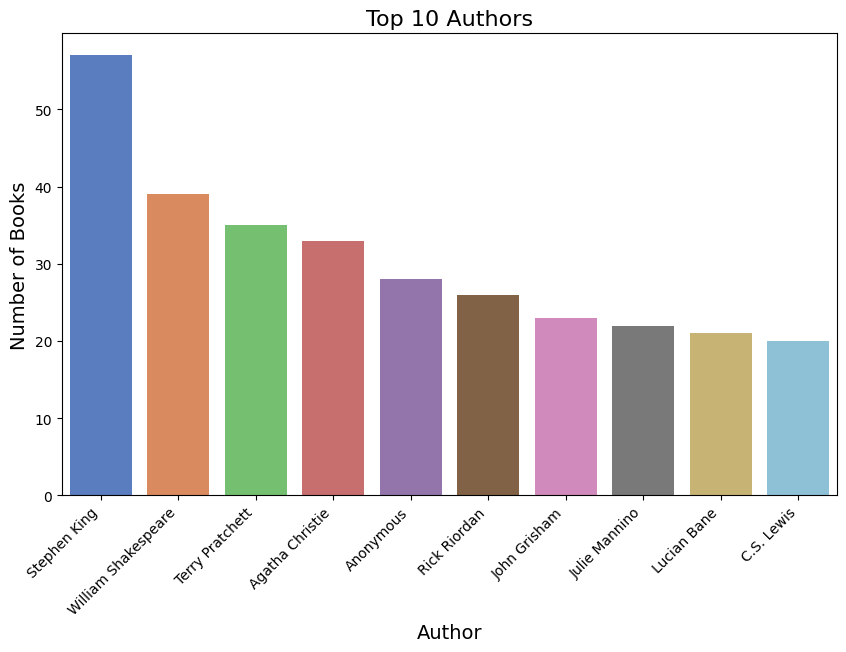

In [24]:
# Group by Author frequency on list
top_authors = df.groupby('Author').size().sort_values(ascending=False).head(10)

# Convert the Series to a DataFrame
df_authors = pd.DataFrame({'Author': top_authors.index, 'Number of Books': top_authors.values})

# Create a bar chart of the most frequent 10 Authors on the list
plt.figure(figsize=(10, 6))
sns.barplot(x='Author', y='Number of Books', data=df_authors, palette='muted')

plt.title('Top 10 Authors', fontsize=16)
plt.xlabel('Author', fontsize=14)
plt.ylabel('Number of Books', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.show()

The author with the most books on this list is Steven King. 
Let's look a little further into King's books.  

In [25]:
king_books = df[df['Author'] == 'Stephen King']

In [26]:
king_books

,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,Fiction
90,The Stand,Stephen King,First came the days of the plague. Then came t...,"['Horror', 'Fiction', 'Fantasy', 'Science Fict...",4.34,722312.0,1
291,The Green Mile,Stephen King,"At Cold Mountain Penitentiary, along the lonel...","['Horror', 'Fiction', 'Fantasy', 'Thriller', '...",4.47,298637.0,1
295,"The Shining (The Shining, #1)",Stephen King,Jack Torrance's new job at the Overlook Hotel ...,"['Horror', 'Fiction', 'Thriller', 'Classics', ...",4.26,1387146.0,1
320,It,Stephen King,"Welcome to Derry, Maine ...It’s a small city, ...","['Horror', 'Fiction', 'Thriller', 'Fantasy', '...",4.25,1026135.0,1
426,Different Seasons,Stephen King,This Book is in Good Condition. Used Copy With...,"['Horror', 'Fiction', 'Short Stories', 'Thrill...",4.35,196795.0,1
446,11/22/63,Stephen King,"On November 22, 1963, three shots rang out in ...","['Fiction', 'Historical Fiction', 'Science Fic...",4.33,502848.0,1
514,On Writing: A Memoir of the Craft,Stephen King,"""Long live the King"" hailed Entertainment Week...","['Nonfiction', 'Writing', 'Memoir', 'Biography...",4.33,270677.0,0
546,Pet Sematary,Stephen King,'This is an alternate Cover Edition for ASIN: ...,"['Horror', 'Fiction', 'Thriller', 'Fantasy', '...",4.05,541803.0,1
557,Carrie,Stephen King,"A modern classic, Carrie introduced a distinct...","['Horror', 'Fiction', 'Thriller', 'Fantasy', '...",3.98,662351.0,1
613,'Salem's Lot,Stephen King,Librarian's Note: Alternate-cover edition for ...,"['Horror', 'Fiction', 'Vampires', 'Fantasy', '...",4.05,417758.0,1


## King's Avg_Rating Distribution 

<Axes: xlabel='Avg_Rating', ylabel='Density'>

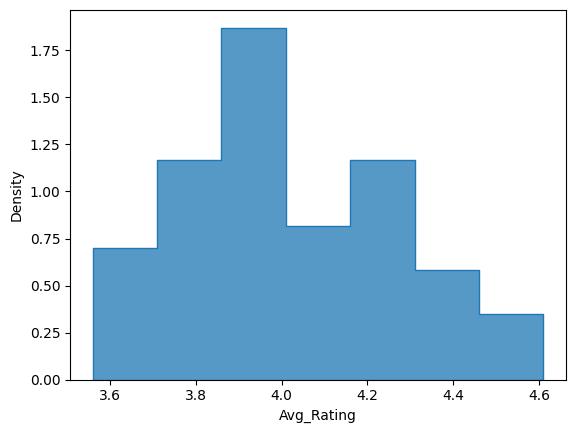

In [27]:
sns.histplot(data=king_books, x='Avg_Rating', element='step', stat='density', common_norm=False)

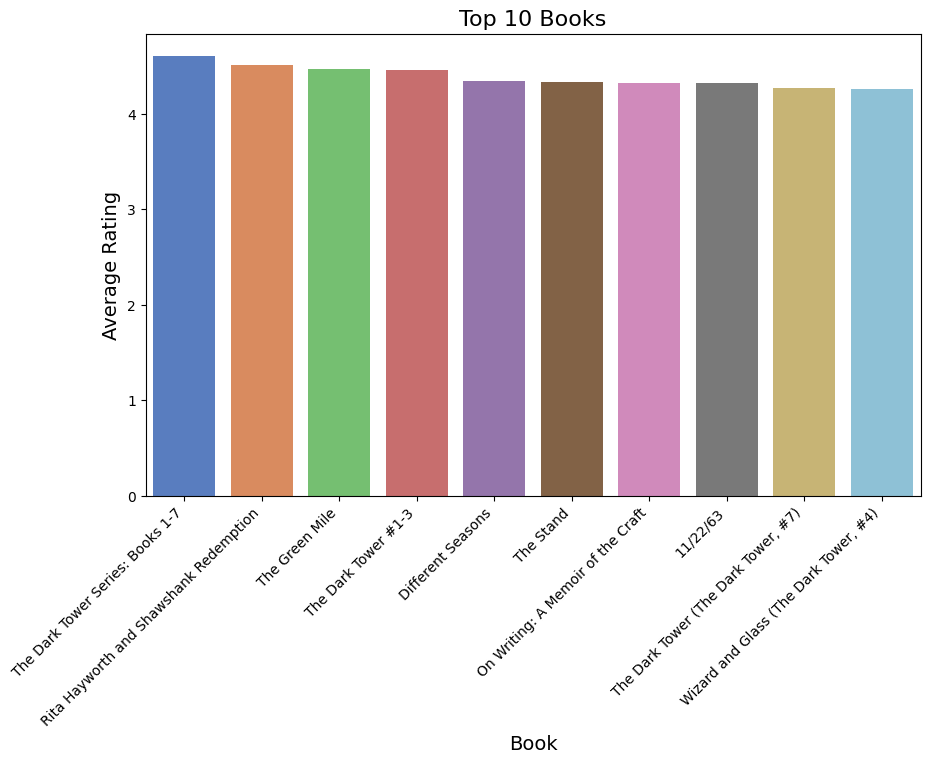

In [28]:
king_books_grouped = king_books.groupby('Book')['Avg_Rating'].mean().sort_values(ascending=False).head(10)

# Convert the Series to a DataFrame
king_books_df = pd.DataFrame({'Book': king_books_grouped.index, 'Avg_Rating': king_books_grouped.values})

# Create a bar chart of King's top 10 books
plt.figure(figsize=(10, 6))
sns.barplot(x='Book', y='Avg_Rating', data=king_books_df, palette='muted')

plt.title('Top 10 Books', fontsize=16)
plt.xlabel('Book', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.show()

In [29]:
king_books_df

,Book,Avg_Rating
0,The Dark Tower Series: Books 1-7,4.61
1,Rita Hayworth and Shawshank Redemption,4.51
2,The Green Mile,4.47
3,The Dark Tower #1-3,4.46
4,Different Seasons,4.35
5,The Stand,4.34
6,On Writing: A Memoir of the Craft,4.33
7,11/22/63,4.33
8,"The Dark Tower (The Dark Tower, #7)",4.27
9,"Wizard and Glass (The Dark Tower, #4)",4.26


<a id="3"></a>
# Natural Language Processing

In [30]:
text = " ".join(describe for describe in df.Description).lower()
print ("There are {} words in the combination of all reviews.".format(len(text)))

There are 9497677 words in the combination of all reviews.


### Wordcloud Test

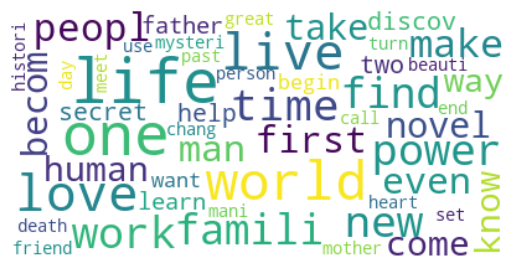

In [31]:
# Set up NLTK tools
# nltk.download('stopwords')
stemmer = SnowballStemmer('english')
stopwords = set(stopwords.words('english'))
stopwords.update(["book", "books", "author", "u", "s", "story", "stories", "read", "reading", "edition", "bestseller", "bestselling", "cover"])

# Preprocess text
text = text.translate(str.maketrans('', '', string.punctuation))
words = text.split()
words = [word for word in words if word not in stopwords]
words = [stemmer.stem(word) for word in words]

# Generate word cloud
wordcloud = WordCloud(background_color='white', max_words=50, max_font_size=50).generate(' '.join(words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Book Shaped Wordcloud

In [32]:
book_mask = np.array(Image.open("book.png"))

In [33]:
# Transform mask pixel values 
def transform_format(val):
    if np.all(val == 0):
        return [255, 255, 255]
    else:
        return [0, 0, 0]

    
transformed_book_mask = np.apply_along_axis(transform_format, 2, book_mask)

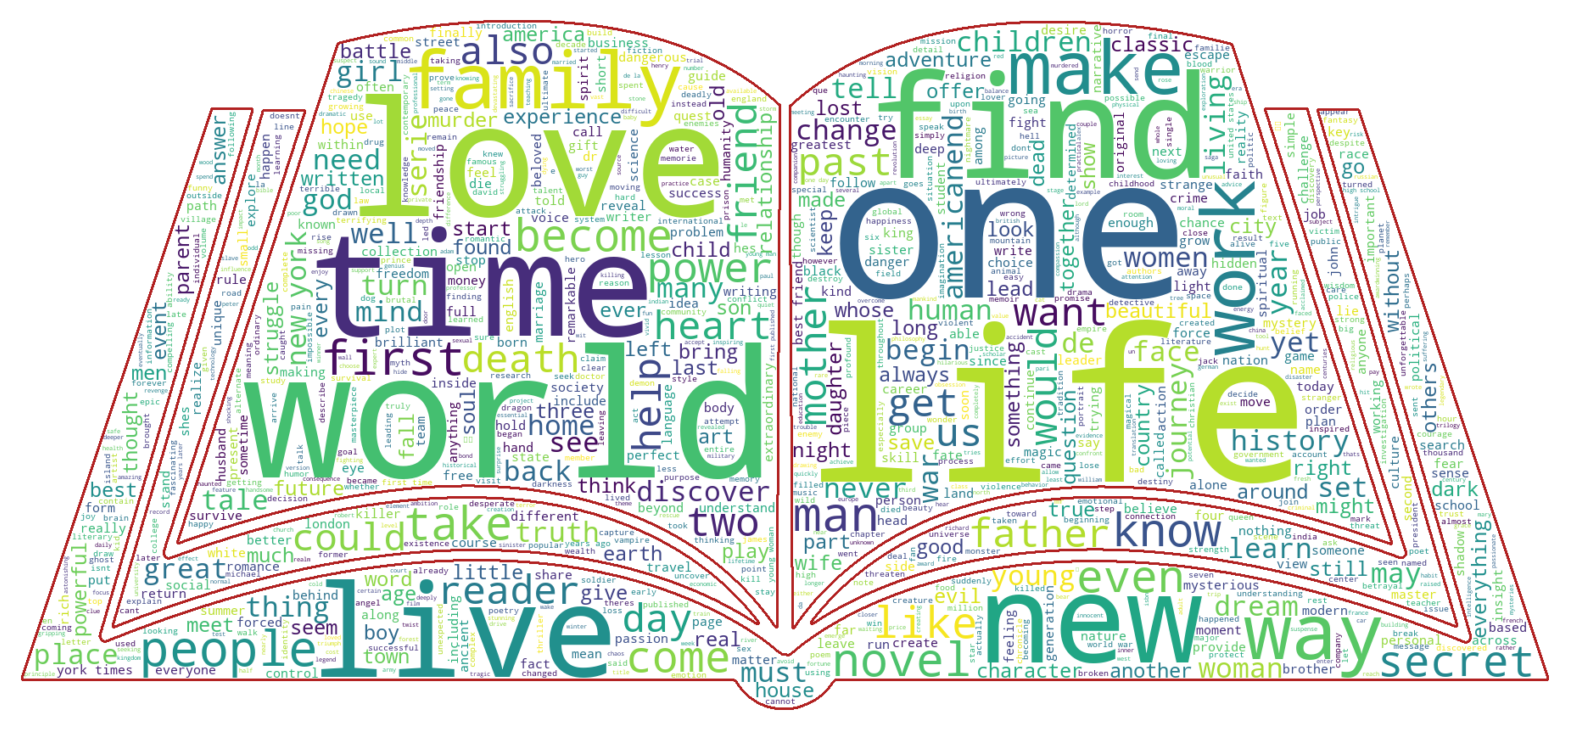

In [34]:
# Create a book shaped word cloud image
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_book_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

# store to file
# wc.to_file("bookcloud.png")

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Now we have a book themed WordCloud that is saved as a PNG file that can be used for other things! 

# Unigram, Bigram, and Trigram Frequency Analysis

In this section of our project, we will see the frequency of words and word combinations. 

In [35]:
df['Review_Text_Lower'] = df['Description'].apply(lambda x: x.lower())
df['Review_Text_NoSw'] = df['Review_Text_Lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
df['Clean_Text'] = df['Review_Text_NoSw'].apply(lambda x: re.sub('[^\w\s]', "", x))

In [36]:
df["Tokenized_Text"] = df["Clean_Text"].apply(nltk.word_tokenize)
df['NLTK_Text'] = df['Tokenized_Text'].apply(nltk.Text)

In [37]:
Counter(" ".join(df['Clean_Text']).split()).most_common(25)

[('life', 5711),
 ('one', 5462),
 ('world', 4145),
 ('new', 4095),
 ('love', 3119),
 ('time', 2545),
 ('first', 2457),
 ('years', 2269),
 ('family', 2035),
 ('man', 1969),
 ('people', 1937),
 ('two', 1882),
 ('novel', 1850),
 ('way', 1811),
 ('young', 1807),
 ('us', 1772),
 ('find', 1734),
 ('even', 1618),
 ('like', 1601),
 ('lives', 1566),
 ('work', 1550),
 ('war', 1503),
 ('never', 1471),
 ('must', 1399),
 ('make', 1380)]

In [38]:
bigrams = collections.Counter()
for phrase in df["NLTK_Text"]:
    try:
        bigrams.update(nltk.bigrams(phrase))
    except StopIteration:
        # Handle the end of the iterator
        print("End of iterator")
    
bigrams_sorted = sorted(bigrams.items(),key=operator.itemgetter(1),reverse=True)
bigrams_sorted[0:15]

[(('new', 'york'), 855),
 (('york', 'times'), 474),
 (('can', 'not'), 272),
 (('world', 'war'), 265),
 (('best', 'friend'), 239),
 (('years', 'ago'), 231),
 (('first', 'time'), 223),
 (('united', 'states'), 211),
 (('young', 'woman'), 183),
 (('years', 'later'), 182),
 (('high', 'school'), 175),
 (('first', 'published'), 174),
 (('one', 'day'), 159),
 (('around', 'world'), 158),
 (('young', 'man'), 151)]

In [39]:
includes_life = []

for bigram in bigrams_sorted:
    if 'life' in bigram[0][0]:
        includes_life.append(bigram)
        
includes_life[0:15]

[(('life', 'death'), 93),
 (('life', 'one'), 52),
 (('life', 'love'), 48),
 (('life', 'forever'), 33),
 (('life', 'never'), 31),
 (('life', 'without'), 27),
 (('life', 'like'), 26),
 (('life', 'work'), 24),
 (('life', 'lived'), 23),
 (('life', 'change'), 23),
 (('life', 'would'), 22),
 (('life', 'new'), 21),
 (('life', 'together'), 20),
 (('life', 'becomes'), 19),
 (('life', 'back'), 19)]

In [40]:
trigrams = collections.Counter()
for phrase in df['NLTK_Text']:
    trigrams.update(nltk.trigrams(phrase))
    
trigrams_sorted = sorted(trigrams.items(),key=operator.itemgetter(1),reverse=True)
trigrams_sorted[0:15]

[(('new', 'york', 'times'), 468),
 (('new', 'york', 'city'), 115),
 (('world', 'war', 'ii'), 115),
 (('1', 'new', 'york'), 101),
 (('tour', 'de', 'force'), 56),
 (('wall', 'street', 'journal'), 33),
 (('librarians', 'note', 'alternate'), 29),
 (('second', 'world', 'war'), 29),
 (('must', 'find', 'way'), 28),
 (('first', 'world', 'war'), 27),
 (('york', 'times', 'bestselling'), 26),
 (('york', 'times', 'review'), 24),
 (('los', 'angeles', 'times'), 23),
 (('major', 'motion', 'picture'), 21),
 (('short', 'isaac', 'asimov'), 21)]

<a id="4"></a>
# Machine Learning Models 

Now we will create a machine learning model to predict whether a book is fiction or not based on the books description. 

In [41]:
# Train-Test Split - We will split our data 80/20 
X_train, X_test, y_train, y_test = train_test_split(df['Clean_Text'], df['Fiction'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)

## Support Vector Classifier (SVC)

In [42]:
# SVC Model Training 
model_svc = SVC()
model_svc.fit(X_train_tfidf, y_train)

# Confusion Matrix
X_test_tfidf = vectorizer.transform(X_test)
y_pred = model_svc.predict(X_test_tfidf)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# K-Fold Cross-Validation
cv_scores = cross_val_score(model_svc, X_train_tfidf, y_train, cv=5) 
print("\nCross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Confusion Matrix:
[[ 501  301]
 [  90 1093]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.62      0.72       802
           1       0.78      0.92      0.85      1183

    accuracy                           0.80      1985
   macro avg       0.82      0.77      0.78      1985
weighted avg       0.81      0.80      0.80      1985


Cross-Validation Scores:
[0.80478589 0.80163728 0.78778338 0.78323882 0.80781348]
Mean Accuracy: 0.80


## Logistic Regression Model 

In [44]:
# Logistic Regression Model Training
model_log = LogisticRegression()
model_log.fit(X_train_tfidf, y_train)

# Confusion Matrix
X_test_tfidf = vectorizer.transform(X_test)
y_pred = model_log.predict(X_test_tfidf)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# K-Fold Cross-Validation
cv_scores = cross_val_score(model_log, X_train_tfidf, y_train, cv=5)
print("\nCross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Confusion Matrix:
[[ 517  285]
 [ 102 1081]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.64      0.73       802
           1       0.79      0.91      0.85      1183

    accuracy                           0.81      1985
   macro avg       0.81      0.78      0.79      1985
weighted avg       0.81      0.81      0.80      1985


Cross-Validation Scores:
[0.80604534 0.7965995  0.78715365 0.78512917 0.80781348]
Mean Accuracy: 0.80
